In [3]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from keras import Model
from tensorflow.keras.optimizers import Adam
# System libraries
from pathlib import Path
import os.path
# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [1]:
#check dataset
import os
import PIL
from PIL import Image
from pathlib import Path
from PIL import UnidentifiedImageError
dataset = "/home/bkcs/NIMA/dataset/Medium/"
#path = Path(dataset).rglob("*.jpg")
for img_p in os.listdir(dataset):
    try:
        #print(img_p)
        img = Image.open(os.path.join(dataset, img_p))
        img.verify()
    except PIL.UnidentifiedImageError:
        print(img_p)
        os.remove(Image.open(os.path.join(dataset, img_p)))

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:822: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


In [25]:
import numpy as np
import os
import glob

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
'''
Checks all images from the AVA dataset if they have corrupted jpegs, and lists them for removal.

Removal must be done manually !
'''

base_images_path = '/home/bkcs/NIMA/dataset/Low/'
ava_dataset_path = '/home/bkcs/NIMA/AVA.txt'


#print(files)
train_image_paths = []
train_scores = []

print("Loading training set and val set")
with open(ava_dataset_path, mode='r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        token = line.split()
        id = int(token[1])

        values = np.array(token[2:12], dtype='float32')
        values /= values.sum()

        file_path = base_images_path + str(id) + '.jpg'
        if os.path.exists(file_path):
            train_image_paths.append(file_path)
            train_scores.append(values)

        count = 255000 // 20
        if i % count == 0 and i != 0:
            print('Loaded %0.2f of the dataset' % (i / 255000. * 100))


train_image_paths = np.array(train_image_paths)
train_scores = np.array(train_scores, dtype='float32')

# val_image_paths = train_image_paths[-50:]
# val_scores = train_scores[-50:]
# train_image_paths = train_image_paths[:-50]
# train_scores = train_scores[:-50]

def parse_data(filename):
    image = tf.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

sess = tf.Session()
with sess.as_default():
    sess.run(tf.global_variables_initializer())

    count = 0
    fn = tf.placeholder(dtype=tf.string)
    img = parse_data(fn)

    for path in train_image_paths:
        try:
            sess.run(img, feed_dict={fn: path})
        except Exception as e:
            print(path, "failed to load !")
            count += 1
            os.remove(path)

    print(count, "images failed to load !")

print("All done !")

Loading training set and val set
Loaded 5.00 of the dataset
Loaded 10.00 of the dataset
Loaded 15.00 of the dataset
Loaded 20.00 of the dataset
Loaded 25.00 of the dataset
Loaded 30.00 of the dataset
Loaded 35.00 of the dataset
Loaded 40.00 of the dataset
Loaded 45.00 of the dataset
Loaded 50.00 of the dataset
Loaded 55.00 of the dataset
Loaded 60.00 of the dataset
Loaded 65.00 of the dataset
Loaded 70.00 of the dataset
Loaded 75.00 of the dataset
Loaded 80.00 of the dataset
Loaded 85.00 of the dataset
Loaded 90.00 of the dataset
Loaded 95.00 of the dataset
Loaded 100.00 of the dataset


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2023-05-18 21:19:45.794101: E tensorflow/core/lib/jpeg/jpeg_mem.cc:324] Premature end of JPEG data. Stopped at line 432/448


/home/bkcs/NIMA/dataset/Low/277832.jpg failed to load !


2023-05-18 21:19:48.169468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1 images failed to load !
All done !


In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from utils.score_utils import mean_score
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# path to the images and the text file which holds the scores and ids
base_images_path = '/home/bkcs/NIMA/dataset/Low/'
ava_dataset_path = '/home/bkcs/NIMA/AVA.txt'

IMAGE_SIZE = 224



train_image_paths = []
train_scores = []

print("Loading training set and val set")
with open(ava_dataset_path, mode='r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        token = line.split()
        id = int(token[1])

        values = np.array(token[2:12], dtype='float32')
        values /= values.sum()
        file_path = base_images_path + str(id) + '.jpg'
        if os.path.exists(file_path):
            train_image_paths.append(file_path)
            train_scores.append(values)

        count = 255000 // 20
        if i % count == 0 and i != 0:
            print('Loaded %d percent of the dataset' % (i / 255000. * 100))

train_image_paths = np.array(train_image_paths)
train_scores = np.array(train_scores, dtype='float32')
# filepaths = pd.Series(train_image_paths, name='Filepath').astype(str)
# labels = pd.Series(train_scores , name='Score')

#     # Concatenate filepaths and labels
# image_df = pd.concat([filepaths, labels], axis=1)
    


print(len(train_image_paths), len(train_scores))
val_image_paths = train_image_paths[-int(len(train_image_paths)*0.1):]
val_scores = train_scores[-int(len(train_image_paths)*0.1):]
test_image_paths = train_image_paths[-int(len(train_image_paths)*0.3):-int(len(train_image_paths)*0.1)]
test_score = train_scores[-int(len(train_image_paths)*0.3):-int(len(train_image_paths)*0.1)]
train_scores = train_scores[:-int(len(train_image_paths)*0.3)]
train_image_paths = train_image_paths[:-int(len(train_image_paths)*0.3)]



print('Train set size : ', train_image_paths.shape, train_scores.shape)
print('Val set size : ', val_image_paths.shape, val_scores.shape)
print('Test set size: ', test_image_paths.shape, test_score.shape)
print('Train and validation datasets ready !')

def parse_data(filename, scores):
    '''
    Loads the image file, and randomly applies crops and flips to each image.

    Args:
        filename: the filename from the record
        scores: the scores from the record

    Returns:
        an image referred to by the filename and its scores
    '''
    image = tf.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, (256, 256))
    image = tf.random_crop(image, size=(IMAGE_SIZE, IMAGE_SIZE, 3))
    image = tf.image.random_flip_left_right(image)
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return image, scores

def parse_data_without_augmentation(filename, scores):
    '''
    Loads the image file without any augmentation. Used for validation set.

    Args:
        filename: the filename from the record
        scores: the scores from the record

    Returns:
        an image referred to by the filename and its scores
    '''
    image = tf.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return image, scores

def train_generator(batchsize, shuffle=True):
    '''
    Creates a python generator that loads the AVA dataset images with random data
    augmentation and generates numpy arrays to feed into the Keras model for training.

    Args:
        batchsize: batchsize for training
        shuffle: whether to shuffle the dataset

    Returns:
        a batch of samples (X_images, y_scores)
    '''
    with tf.Session() as sess:
        # create a dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_scores))
        train_dataset = train_dataset.map(parse_data, num_parallel_calls=2)

        train_dataset = train_dataset.batch(batchsize)
        train_dataset = train_dataset.repeat()
        if shuffle:
            train_dataset = train_dataset.shuffle(buffer_size=4)
        train_iterator = train_dataset.make_initializable_iterator()

        train_batch = train_iterator.get_next()

        sess.run(train_iterator.initializer)

        while True:
            try:
                X_batch, y_batch = sess.run(train_batch)
                yield (X_batch, y_batch)
            except:
                train_iterator = train_dataset.make_initializable_iterator()
                sess.run(train_iterator.initializer)
                train_batch = train_iterator.get_next()

                X_batch, y_batch = sess.run(train_batch)
                yield (X_batch, y_batch)

def val_generator(batchsize):
    '''
    Creates a python generator that loads the AVA dataset images without random data
    augmentation and generates numpy arrays to feed into the Keras model for training.

    Args:
        batchsize: batchsize for validation set

    Returns:
        a batch of samples (X_images, y_scores)
    '''
    with tf.Session() as sess:
        val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_scores))
        val_dataset = val_dataset.map(parse_data_without_augmentation)

        val_dataset = val_dataset.batch(batchsize)
        val_dataset = val_dataset.repeat()
        val_iterator = val_dataset.make_initializable_iterator()

        val_batch = val_iterator.get_next()

        sess.run(val_iterator.initializer)

        while True:
            try:
                X_batch, y_batch = sess.run(val_batch)
                yield (X_batch, y_batch)
            except:
                val_iterator = val_dataset.make_initializable_iterator()
                sess.run(val_iterator.initializer)
                val_batch = val_iterator.get_next()

                X_batch, y_batch = sess.run(val_batch)
                yield (X_batch, y_batch)

Instructions for updating:
non-resource variables are not supported in the long term
Loading training set and val set
Loaded 5 percent of the dataset
Loaded 10 percent of the dataset
Loaded 15 percent of the dataset
Loaded 20 percent of the dataset
Loaded 25 percent of the dataset
Loaded 30 percent of the dataset
Loaded 35 percent of the dataset
Loaded 40 percent of the dataset
Loaded 45 percent of the dataset
Loaded 50 percent of the dataset
Loaded 55 percent of the dataset
Loaded 60 percent of the dataset
Loaded 65 percent of the dataset
Loaded 70 percent of the dataset
Loaded 75 percent of the dataset
Loaded 80 percent of the dataset
Loaded 85 percent of the dataset
Loaded 90 percent of the dataset
Loaded 95 percent of the dataset
Loaded 100 percent of the dataset
7828 7828
Train set size :  (5480,) (5480, 10)
Val set size :  (782,) (782, 10)
Test set size:  (1566,) (1566, 10)
Train and validation datasets ready !


In [4]:
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.losses import mean_squared_error
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
'''
Below is a modification to the TensorBoard callback to perform
batchwise writing to the tensorboard, instead of only at the end
of the batch.
'''
def earth_mover_loss(y_true, y_pred):
    cdf_ytrue = K.cumsum(y_true, axis=-1)
    cdf_ypred = K.cumsum(y_pred, axis=-1)
    samplewise_emd = K.sqrt(K.mean(K.square(K.abs(cdf_ytrue - cdf_ypred)), axis=-1))
    return K.mean(samplewise_emd)
image_size = 224
base_model = EfficientNetB4(input_shape=(image_size, image_size, 3), include_top=False, pooling='avg', weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
x = Dense(128, activation='relu')(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.75)(x)

x = Dense(10, activation='softmax')(x)

model = Model(base_model.input, x)
model.summary()
optimizer = Adam(2e-3)
model.compile(optimizer, loss=earth_mover_loss,metrics=[earth_mover_loss])

#load weights from trained model if it exists
# if os.path.exists('/home/bkcs/NIMA/weights/efficientNetB2_weights_Low(Best).h5'):
#    print("weights exists")
#    model.load_weights('/home/bkcs/NIMA/weights/efficientNetB2_weights_Low(Best).h5')

checkpoint = ModelCheckpoint('/home/bkcs/NIMA/weights/efficientNetB4_weights_Medium(official).h5', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True,
                             mode='min')
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 20,
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-6)

callbacks = [checkpoint, early_stopping, reduce_lr]



history=model.fit(train_generator(batchsize=32),
                    steps_per_epoch=len(train_scores)//32, ##Need to change
                    epochs=40, verbose=1, callbacks=callbacks,
                    validation_data=val_generator(batchsize=32),
                    validation_steps=(len(val_scores))//32)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                              

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 57/171 [=========>....................] - ETA: 12s - batch: 28.0000 - size: 32.0000 - loss: 0.2729 - earth_mover_loss: 0.2729

2023-05-22 18:28:56.436441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.2276 - earth_mover_loss: 0.2276

/home/bkcs/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.14570, saving model to /home/bkcs/NIMA/weights/efficientNetB4_weights_Medium(official).h5
171/171 [==============================] - 69s 362ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.2276 - earth_mover_loss: 0.2276 - val_loss: 0.1457 - val_earth_mover_loss: 0.1457 - lr: 0.0020
Epoch 2/40
 11/171 [>.............................] - ETA: 17s - batch: 5.0000 - size: 32.0000 - loss: 0.1891 - earth_mover_loss: 0.1891

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 58/171 [=========>....................] - ETA: 12s - batch: 28.5000 - size: 32.0000 - loss: 0.1818 - earth_mover_loss: 0.1818

2023-05-22 18:29:58.252620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 32.0000 - loss: 0.1712 - earth_mover_loss: 0.1712
Epoch 2: val_loss did not improve from 0.14570
171/171 [==============================] - 22s 127ms/step - batch: 85.0000 - size: 32.0000 - loss: 0.1712 - earth_mover_loss: 0.1712 - val_loss: 0.2193 - val_earth_mover_loss: 0.2193 - lr: 0.0020
Epoch 3/40
 12/171 [=>............................] - ETA: 18s - batch: 5.5000 - size: 30.0000 - loss: 0.1569 - earth_mover_loss: 0.1569

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 59/171 [=========>....................] - ETA: 12s - batch: 29.0000 - size: 31.5932 - loss: 0.1520 - earth_mover_loss: 0.1520

2023-05-22 18:30:20.093499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/171 [============================>.] - ETA: 0s - batch: 84.5000 - size: 31.8588 - loss: 0.1373 - earth_mover_loss: 0.1373
Epoch 3: val_loss did not improve from 0.14570
171/171 [==============================] - 21s 126ms/step - batch: 85.0000 - size: 31.7193 - loss: 0.1370 - earth_mover_loss: 0.1370 - val_loss: 0.2189 - val_earth_mover_loss: 0.2189 - lr: 0.0020
Epoch 4/40
 13/171 [=>............................] - ETA: 17s - batch: 6.0000 - size: 32.0000 - loss: 0.1094 - earth_mover_loss: 0.1094

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 60/171 [=========>....................] - ETA: 12s - batch: 29.5000 - size: 32.0000 - loss: 0.1042 - earth_mover_loss: 0.1042

2023-05-22 18:30:41.655301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 32.0000 - loss: 0.0917 - earth_mover_loss: 0.0917
Epoch 4: val_loss did not improve from 0.14570
171/171 [==============================] - 21s 125ms/step - batch: 85.0000 - size: 32.0000 - loss: 0.0917 - earth_mover_loss: 0.0917 - val_loss: 0.1625 - val_earth_mover_loss: 0.1625 - lr: 0.0020
Epoch 5/40
 14/171 [=>............................] - ETA: 16s - batch: 6.5000 - size: 30.2857 - loss: 0.0744 - earth_mover_loss: 0.0744

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 61/171 [=========>....................] - ETA: 12s - batch: 30.0000 - size: 31.6066 - loss: 0.0714 - earth_mover_loss: 0.0714

2023-05-22 18:31:02.954033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0668 - earth_mover_loss: 0.0668
Epoch 5: val_loss improved from 0.14570 to 0.07983, saving model to /home/bkcs/NIMA/weights/efficientNetB4_weights_Medium(official).h5
171/171 [==============================] - 22s 130ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0668 - earth_mover_loss: 0.0668 - val_loss: 0.0798 - val_earth_mover_loss: 0.0798 - lr: 0.0020
Epoch 6/40
 15/171 [=>............................] - ETA: 17s - batch: 7.0000 - size: 30.4000 - loss: 0.0598 - earth_mover_loss: 0.0598

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 62/171 [=========>....................] - ETA: 11s - batch: 30.5000 - size: 31.6129 - loss: 0.0592 - earth_mover_loss: 0.0592

2023-05-22 18:31:25.197125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0586 - earth_mover_loss: 0.0586
Epoch 6: val_loss did not improve from 0.07983
171/171 [==============================] - 21s 125ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0586 - earth_mover_loss: 0.0586 - val_loss: 0.1003 - val_earth_mover_loss: 0.1003 - lr: 0.0020
Epoch 7/40
 16/171 [=>............................] - ETA: 16s - batch: 7.5000 - size: 30.5000 - loss: 0.0536 - earth_mover_loss: 0.0536

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 63/171 [==========>...................] - ETA: 11s - batch: 31.0000 - size: 31.6190 - loss: 0.0549 - earth_mover_loss: 0.0549

2023-05-22 18:31:46.557943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0549 - earth_mover_loss: 0.0549
Epoch 7: val_loss improved from 0.07983 to 0.06571, saving model to /home/bkcs/NIMA/weights/efficientNetB4_weights_Medium(official).h5
171/171 [==============================] - 22s 127ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0549 - earth_mover_loss: 0.0549 - val_loss: 0.0657 - val_earth_mover_loss: 0.0657 - lr: 0.0020
Epoch 8/40
 17/171 [=>............................] - ETA: 15s - batch: 8.0000 - size: 30.5882 - loss: 0.0536 - earth_mover_loss: 0.0536

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 64/171 [==========>...................] - ETA: 11s - batch: 31.5000 - size: 31.6250 - loss: 0.0529 - earth_mover_loss: 0.0529

2023-05-22 18:32:08.515628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0540 - earth_mover_loss: 0.0540
Epoch 8: val_loss did not improve from 0.06571
171/171 [==============================] - 21s 124ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0540 - earth_mover_loss: 0.0540 - val_loss: 0.0852 - val_earth_mover_loss: 0.0852 - lr: 0.0020
Epoch 9/40
 18/171 [==>...........................] - ETA: 16s - batch: 8.5000 - size: 30.6667 - loss: 0.0518 - earth_mover_loss: 0.0518

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 65/171 [==========>...................] - ETA: 11s - batch: 32.0000 - size: 31.6308 - loss: 0.0518 - earth_mover_loss: 0.0518

2023-05-22 18:32:29.866644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0533 - earth_mover_loss: 0.0533
Epoch 9: val_loss did not improve from 0.06571
171/171 [==============================] - 21s 124ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0533 - earth_mover_loss: 0.0533 - val_loss: 0.1348 - val_earth_mover_loss: 0.1348 - lr: 0.0020
Epoch 10/40
 19/171 [==>...........................] - ETA: 16s - batch: 9.0000 - size: 30.7368 - loss: 0.0512 - earth_mover_loss: 0.0512

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 66/171 [==========>...................] - ETA: 11s - batch: 32.5000 - size: 31.6364 - loss: 0.0519 - earth_mover_loss: 0.0519

2023-05-22 18:32:51.166363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0529 - earth_mover_loss: 0.0529
Epoch 10: val_loss did not improve from 0.06571
171/171 [==============================] - 21s 124ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0529 - earth_mover_loss: 0.0529 - val_loss: 0.0904 - val_earth_mover_loss: 0.0904 - lr: 0.0020
Epoch 11/40
 20/171 [==>...........................] - ETA: 16s - batch: 9.5000 - size: 30.8000 - loss: 0.0495 - earth_mover_loss: 0.0495

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 67/171 [==========>...................] - ETA: 11s - batch: 33.0000 - size: 31.6418 - loss: 0.0507 - earth_mover_loss: 0.0507

2023-05-22 18:33:12.515092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0523 - earth_mover_loss: 0.0523
Epoch 11: val_loss did not improve from 0.06571
171/171 [==============================] - 22s 126ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0523 - earth_mover_loss: 0.0523 - val_loss: 0.1502 - val_earth_mover_loss: 0.1502 - lr: 0.0020
Epoch 12/40
 21/171 [==>...........................] - ETA: 15s - batch: 10.0000 - size: 30.8571 - loss: 0.0504 - earth_mover_loss: 0.0504

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 68/171 [==========>...................] - ETA: 11s - batch: 33.5000 - size: 31.6471 - loss: 0.0505 - earth_mover_loss: 0.0505

2023-05-22 18:33:34.303812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0517 - earth_mover_loss: 0.0517
Epoch 12: val_loss did not improve from 0.06571
171/171 [==============================] - 22s 127ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0517 - earth_mover_loss: 0.0517 - val_loss: 0.0791 - val_earth_mover_loss: 0.0791 - lr: 0.0020
Epoch 13/40
 22/171 [==>...........................] - ETA: 16s - batch: 10.5000 - size: 30.9091 - loss: 0.0491 - earth_mover_loss: 0.0491

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 69/171 [===========>..................] - ETA: 11s - batch: 34.0000 - size: 31.6522 - loss: 0.0501 - earth_mover_loss: 0.0501

2023-05-22 18:33:55.884032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0512 - earth_mover_loss: 0.0512
Epoch 13: val_loss improved from 0.06571 to 0.04889, saving model to /home/bkcs/NIMA/weights/efficientNetB4_weights_Medium(official).h5
171/171 [==============================] - 22s 130ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0512 - earth_mover_loss: 0.0512 - val_loss: 0.0489 - val_earth_mover_loss: 0.0489 - lr: 0.0020
Epoch 14/40
 23/171 [===>..........................] - ETA: 16s - batch: 11.0000 - size: 30.9565 - loss: 0.0502 - earth_mover_loss: 0.0502

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 70/171 [===========>..................] - ETA: 11s - batch: 34.5000 - size: 31.6571 - loss: 0.0492 - earth_mover_loss: 0.0492

2023-05-22 18:34:18.253193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0508 - earth_mover_loss: 0.0508
Epoch 14: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 123ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0508 - earth_mover_loss: 0.0508 - val_loss: 0.0544 - val_earth_mover_loss: 0.0544 - lr: 0.0020
Epoch 15/40
 24/171 [===>..........................] - ETA: 15s - batch: 11.5000 - size: 31.0000 - loss: 0.0494 - earth_mover_loss: 0.0494

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 71/171 [===========>..................] - ETA: 10s - batch: 35.0000 - size: 31.6620 - loss: 0.0497 - earth_mover_loss: 0.0497

2023-05-22 18:34:39.192947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0505 - earth_mover_loss: 0.0505
Epoch 15: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0505 - earth_mover_loss: 0.0505 - val_loss: 0.0570 - val_earth_mover_loss: 0.0570 - lr: 0.0020
Epoch 16/40
 25/171 [===>..........................] - ETA: 15s - batch: 12.0000 - size: 31.0400 - loss: 0.0481 - earth_mover_loss: 0.0481

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 72/171 [===========>..................] - ETA: 10s - batch: 35.5000 - size: 31.6667 - loss: 0.0494 - earth_mover_loss: 0.0494

2023-05-22 18:35:00.154635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0502 - earth_mover_loss: 0.0502
Epoch 16: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0502 - earth_mover_loss: 0.0502 - val_loss: 0.0490 - val_earth_mover_loss: 0.0490 - lr: 0.0020
Epoch 17/40
 26/171 [===>..........................] - ETA: 15s - batch: 12.5000 - size: 31.0769 - loss: 0.0481 - earth_mover_loss: 0.0481

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 73/171 [===========>..................] - ETA: 10s - batch: 36.0000 - size: 31.6712 - loss: 0.0490 - earth_mover_loss: 0.0490

2023-05-22 18:35:21.087909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0497 - earth_mover_loss: 0.0497
Epoch 17: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0497 - earth_mover_loss: 0.0497 - val_loss: 0.0692 - val_earth_mover_loss: 0.0692 - lr: 0.0020
Epoch 18/40
 27/171 [===>..........................] - ETA: 15s - batch: 13.0000 - size: 31.1111 - loss: 0.0487 - earth_mover_loss: 0.0487

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 74/171 [===========>..................] - ETA: 10s - batch: 36.5000 - size: 31.6757 - loss: 0.0487 - earth_mover_loss: 0.0487

2023-05-22 18:35:41.982279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0493 - earth_mover_loss: 0.0493
Epoch 18: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0493 - earth_mover_loss: 0.0493 - val_loss: 0.0687 - val_earth_mover_loss: 0.0687 - lr: 0.0020
Epoch 19/40
 28/171 [===>..........................] - ETA: 15s - batch: 13.5000 - size: 31.1429 - loss: 0.0490 - earth_mover_loss: 0.0490

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 75/171 [============>.................] - ETA: 10s - batch: 37.0000 - size: 31.6800 - loss: 0.0484 - earth_mover_loss: 0.0484

2023-05-22 18:36:02.869526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0488 - earth_mover_loss: 0.0488
Epoch 19: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 125ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0488 - earth_mover_loss: 0.0488 - val_loss: 0.0647 - val_earth_mover_loss: 0.0647 - lr: 0.0020
Epoch 20/40
 29/171 [====>.........................] - ETA: 14s - batch: 14.0000 - size: 31.1724 - loss: 0.0473 - earth_mover_loss: 0.0473

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 76/171 [============>.................] - ETA: 10s - batch: 37.5000 - size: 31.6842 - loss: 0.0470 - earth_mover_loss: 0.0470

2023-05-22 18:36:24.262927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0473 - earth_mover_loss: 0.0473
Epoch 20: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 121ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0473 - earth_mover_loss: 0.0473 - val_loss: 0.0768 - val_earth_mover_loss: 0.0768 - lr: 4.0000e-04
Epoch 21/40
 30/171 [====>.........................] - ETA: 14s - batch: 14.5000 - size: 31.2000 - loss: 0.0460 - earth_mover_loss: 0.0460

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 77/171 [============>.................] - ETA: 10s - batch: 38.0000 - size: 31.6883 - loss: 0.0458 - earth_mover_loss: 0.0458

2023-05-22 18:36:45.077714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0468 - earth_mover_loss: 0.0468
Epoch 21: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0468 - earth_mover_loss: 0.0468 - val_loss: 0.0677 - val_earth_mover_loss: 0.0677 - lr: 4.0000e-04
Epoch 22/40
 31/171 [====>.........................] - ETA: 14s - batch: 15.0000 - size: 31.2258 - loss: 0.0461 - earth_mover_loss: 0.0461

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 78/171 [============>.................] - ETA: 10s - batch: 38.5000 - size: 31.6923 - loss: 0.0458 - earth_mover_loss: 0.0458

2023-05-22 18:37:06.045346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0466 - earth_mover_loss: 0.0466
Epoch 22: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0466 - earth_mover_loss: 0.0466 - val_loss: 0.0651 - val_earth_mover_loss: 0.0651 - lr: 4.0000e-04
Epoch 23/40
 32/171 [====>.........................] - ETA: 14s - batch: 15.5000 - size: 31.2500 - loss: 0.0455 - earth_mover_loss: 0.0455

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 79/171 [============>.................] - ETA: 9s - batch: 39.0000 - size: 31.6962 - loss: 0.0456 - earth_mover_loss: 0.0456 

2023-05-22 18:37:26.912343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0465 - earth_mover_loss: 0.0465
Epoch 23: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 121ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0465 - earth_mover_loss: 0.0465 - val_loss: 0.0996 - val_earth_mover_loss: 0.0996 - lr: 4.0000e-04
Epoch 24/40
 33/171 [====>.........................] - ETA: 14s - batch: 16.0000 - size: 31.2727 - loss: 0.0454 - earth_mover_loss: 0.0454

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 80/171 [=============>................] - ETA: 9s - batch: 39.5000 - size: 31.7000 - loss: 0.0453 - earth_mover_loss: 0.0453

2023-05-22 18:37:47.773037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0465 - earth_mover_loss: 0.0465
Epoch 24: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0465 - earth_mover_loss: 0.0465 - val_loss: 0.0762 - val_earth_mover_loss: 0.0762 - lr: 4.0000e-04
Epoch 25/40
 34/171 [====>.........................] - ETA: 14s - batch: 16.5000 - size: 31.2941 - loss: 0.0458 - earth_mover_loss: 0.0458

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 81/171 [=============>................] - ETA: 9s - batch: 40.0000 - size: 31.7037 - loss: 0.0456 - earth_mover_loss: 0.0456

2023-05-22 18:38:08.661511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0466 - earth_mover_loss: 0.0466
Epoch 25: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0466 - earth_mover_loss: 0.0466 - val_loss: 0.0738 - val_earth_mover_loss: 0.0738 - lr: 4.0000e-04
Epoch 26/40
 35/171 [=====>........................] - ETA: 14s - batch: 17.0000 - size: 31.3143 - loss: 0.0457 - earth_mover_loss: 0.0457

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 82/171 [=============>................] - ETA: 9s - batch: 40.5000 - size: 31.7073 - loss: 0.0455 - earth_mover_loss: 0.0455

2023-05-22 18:38:29.650237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0462 - earth_mover_loss: 0.0462
Epoch 26: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0462 - earth_mover_loss: 0.0462 - val_loss: 0.0657 - val_earth_mover_loss: 0.0657 - lr: 8.0000e-05
Epoch 27/40
 36/171 [=====>........................] - ETA: 14s - batch: 17.5000 - size: 31.3333 - loss: 0.0452 - earth_mover_loss: 0.0452

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 83/171 [=============>................] - ETA: 9s - batch: 41.0000 - size: 31.7108 - loss: 0.0449 - earth_mover_loss: 0.0449

2023-05-22 18:38:50.677765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0459 - earth_mover_loss: 0.0459
Epoch 27: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0459 - earth_mover_loss: 0.0459 - val_loss: 0.0726 - val_earth_mover_loss: 0.0726 - lr: 8.0000e-05
Epoch 28/40
 37/171 [=====>........................] - ETA: 14s - batch: 18.0000 - size: 31.3514 - loss: 0.0452 - earth_mover_loss: 0.0452

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 84/171 [=============>................] - ETA: 9s - batch: 41.5000 - size: 31.7143 - loss: 0.0448 - earth_mover_loss: 0.0448

2023-05-22 18:39:11.629313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0457 - earth_mover_loss: 0.0457
Epoch 28: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0457 - earth_mover_loss: 0.0457 - val_loss: 0.0762 - val_earth_mover_loss: 0.0762 - lr: 8.0000e-05
Epoch 29/40
 38/171 [=====>........................] - ETA: 14s - batch: 18.5000 - size: 31.3684 - loss: 0.0456 - earth_mover_loss: 0.0456

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 85/171 [=============>................] - ETA: 9s - batch: 42.0000 - size: 31.7176 - loss: 0.0453 - earth_mover_loss: 0.0453

2023-05-22 18:39:32.508474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0459 - earth_mover_loss: 0.0459
Epoch 29: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0459 - earth_mover_loss: 0.0459 - val_loss: 0.0710 - val_earth_mover_loss: 0.0710 - lr: 8.0000e-05
Epoch 30/40
 39/171 [=====>........................] - ETA: 14s - batch: 19.0000 - size: 31.3846 - loss: 0.0452 - earth_mover_loss: 0.0452

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 86/171 [==============>...............] - ETA: 9s - batch: 42.5000 - size: 31.7209 - loss: 0.0449 - earth_mover_loss: 0.0449

2023-05-22 18:39:53.485564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0457 - earth_mover_loss: 0.0457
Epoch 30: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 121ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0457 - earth_mover_loss: 0.0457 - val_loss: 0.0744 - val_earth_mover_loss: 0.0744 - lr: 8.0000e-05
Epoch 31/40
 40/171 [======>.......................] - ETA: 14s - batch: 19.5000 - size: 31.4000 - loss: 0.0451 - earth_mover_loss: 0.0451

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 87/171 [==============>...............] - ETA: 9s - batch: 43.0000 - size: 31.7241 - loss: 0.0448 - earth_mover_loss: 0.0448

2023-05-22 18:40:14.335366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0456 - earth_mover_loss: 0.0456
Epoch 31: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 122ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0456 - earth_mover_loss: 0.0456 - val_loss: 0.0780 - val_earth_mover_loss: 0.0780 - lr: 8.0000e-05
Epoch 32/40
 41/171 [======>.......................] - ETA: 13s - batch: 20.0000 - size: 31.4146 - loss: 0.0453 - earth_mover_loss: 0.0453

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 88/171 [==============>...............] - ETA: 8s - batch: 43.5000 - size: 31.7273 - loss: 0.0452 - earth_mover_loss: 0.0452

2023-05-22 18:40:35.297774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0458 - earth_mover_loss: 0.0458
Epoch 32: val_loss did not improve from 0.04889
171/171 [==============================] - 21s 121ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0458 - earth_mover_loss: 0.0458 - val_loss: 0.0743 - val_earth_mover_loss: 0.0743 - lr: 1.6000e-05
Epoch 33/40
 42/171 [======>.......................] - ETA: 13s - batch: 20.5000 - size: 31.4286 - loss: 0.0456 - earth_mover_loss: 0.0456

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


 89/171 [==============>...............] - ETA: 8s - batch: 44.0000 - size: 31.7303 - loss: 0.0447 - earth_mover_loss: 0.0447

2023-05-22 18:40:56.162196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/171 [==============================] - ETA: 0s - batch: 85.0000 - size: 31.8596 - loss: 0.0457 - earth_mover_loss: 0.0457
Epoch 33: val_loss did not improve from 0.04889
171/171 [==============================] - 22s 131ms/step - batch: 85.0000 - size: 31.8596 - loss: 0.0457 - earth_mover_loss: 0.0457 - val_loss: 0.0748 - val_earth_mover_loss: 0.0748 - lr: 1.6000e-05


Exception ignored in: <generator object val_generator at 0x7f52a4193d80>
Traceback (most recent call last):
  File "/tmp/ipykernel_20636/44657148.py", line 164, in val_generator
  File "/home/bkcs/.local/lib/python3.10/site-packages/tensorflow/python/util/deprecation.py", line 344, in new_func
    return func(*args, **kwargs)
  File "/home/bkcs/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 3622, in make_initializable_iterator
    return self._make_initializable_iterator(shared_name)
  File "/home/bkcs/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 3628, in _make_initializable_iterator
    _ensure_same_dataset_graph(self)
  File "/home/bkcs/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 4006, in _ensure_same_dataset_graph
    raise ValueError(
ValueError: The graph <tensorflow.python.framework.ops.Graph object at 0x7f53bdc04af0> of the iterator is different from the graph <

In [15]:
# from utils.score_utils import mean_score
from keras.applications.efficientnet import EfficientNetB2
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
from keras.applications.efficientnet import preprocess_input
# from sklearn.metrics import mean_squared_error
image_size = 224
base_model = EfficientNetB4(input_shape=(image_size, image_size, 3), include_top=False, pooling='avg', weights='imagenet')
x = Dense(128, activation='relu')(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.75)(x)

x = Dense(10, activation='softmax')(x)

model = Model(base_model.input, x)

if os.path.exists('/home/bkcs/NIMA/weights/efficientNetB4_weights_Medium(official).h5'):
    print("weights exists")
    model.load_weights('/home/bkcs/NIMA/weights/efficientNetB4_weights_Medium(official).h5')
score_list=[]
score_dist_list=[]
target_size = (224, 224) 
for img_path in test_image_paths:
        img = load_img(img_path, target_size=target_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        x = preprocess_input(x)

        scores = model.predict(x, batch_size=1, verbose=0)[0]
        score_dist_list.append(scores)
        mean = mean_score(scores)
        #print(mean)

        score_list.append(mean)
test_score_mean=[]
for value in test_score:
        test_score_mean.append(mean_score(value))
# print("MSE Loss on Medium: ", mean_squared_error(score_list, test_score_mean))
#print("EMD loss on Medium: ", earth_mover_loss(test_score, score_dist_list))

weights exists


/home/bkcs/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [21]:
#print(score_dist_list)
#print(type(test_score))
score_dist_list=np.array(score_dist_list)

value = tf.compat.v1.Session().run(earth_mover_loss(score_dist_list,test_score))
print("EMD on Low: ",value)

EMD on Low:  0.033814643


In [ ]:
from sklearn.metrics import mean_squared_error
print("MSE Loss on Low: ", mean_squared_error(score_list, test_score_mean))

MSE Loss on Medium:  0.06293537492671525


In [20]:
from keras import backend as K
def earth_mover_loss(y_true, y_pred):
    cdf_ytrue = K.cumsum(y_true, axis=-1)
    cdf_ypred = K.cumsum(y_pred, axis=-1)
    samplewise_emd = K.mean(K.abs(cdf_ytrue - cdf_ypred), axis=-1)
    return K.mean(samplewise_emd)

In [26]:
import numpy as np
from scipy.stats import spearmanr

# Sample data
x = np.array(score_list)
y = np.array(test_score_mean)

sorted_index=np.argsort(x)
x=x[sorted_index]
y=y[sorted_index]
# Linear correlation coefficient (Pearson's correlation coefficient)
r = np.corrcoef(x, y)[1][0]  
print("Linear correlation coefficient (r):", r)

# Spearman's rank correlation coefficient
rho = spearmanr(x, y)[0]
print("Spearman's rank correlation coefficient (ρ):", rho)

Linear correlation coefficient (r): -0.011462765526150855
Spearman's rank correlation coefficient (ρ): -0.005708184277102443


In [28]:
print(y[0:20])
print(x[0:20])

[2.84545457 3.82938386 3.72102999 3.90140834 3.81025657 3.02189779
 3.99999994 3.34328351 3.92376682 3.70114936 3.68131877 3.79581157
 3.7073171  3.6111111  3.63000004 3.73295453 3.83177576 3.66666678
 3.9152542  3.53333338]
[3.47172214 3.50161395 3.51619411 3.51925349 3.51950073 3.55191789
 3.56251123 3.56716895 3.56979198 3.57345137 3.57972741 3.58044533
 3.58313297 3.58874361 3.59017274 3.59118765 3.59246614 3.59620079
 3.59710529 3.60168062]


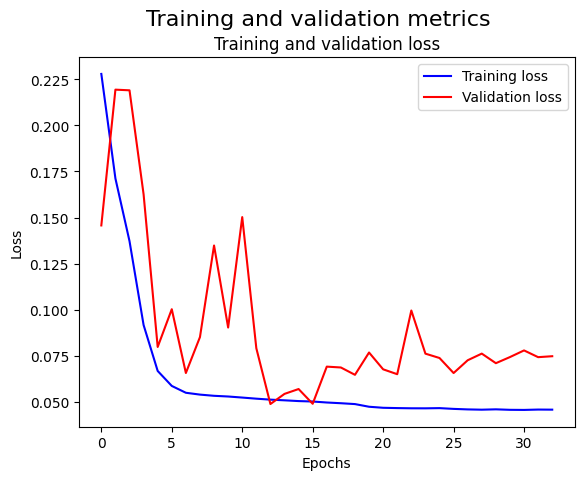

In [10]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))



plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Training and validation metrics', fontsize=16)
plt.show()

In [23]:
print(test_score[0])
print(score_dist_list[0])

[0.16666667 0.11231884 0.13405797 0.1521739  0.25724638 0.0615942
 0.06521739 0.02898551 0.01449275 0.00724638]
[0.0855527  0.1297029  0.20899673 0.28724065 0.18378258 0.06388822
 0.03238729 0.00396268 0.00240746 0.00207874]


Histogram on all cls


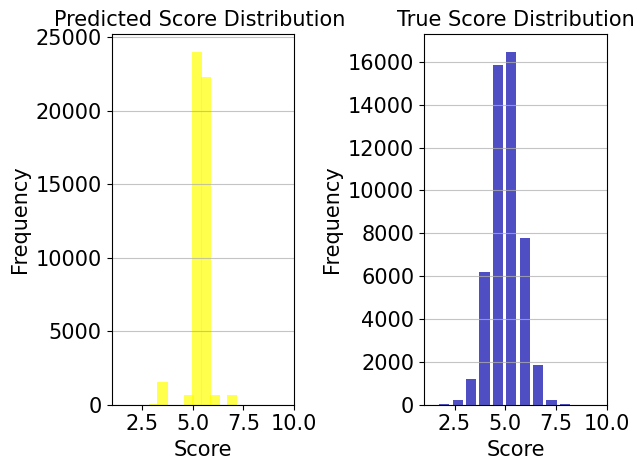

In [64]:
hist, bin_edges = np.histogram(score_list)
hist2, bin_edges2 = np.histogram(test_score_mean)
#plt.hist(test_score_mean, bins=[1,2,3,4,5,6,7,8,9,10],label="Test", color="red")
#plt.figure(figsize=[10,8])
plt.subplot(1,2,1)
plt.bar(bin_edges[:-1], hist, width = 0.5, color='yellow',alpha=0.7)
plt.xlim(1, 10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Score',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Predicted Score Distribution ',fontsize=15)
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(bin_edges2[:-1], hist2, width = 0.5, color='#0504aa',alpha=0.7)
plt.xlim(1, 10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Score',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('True Score Distribution',fontsize=15)
plt.tight_layout()
plt.show()



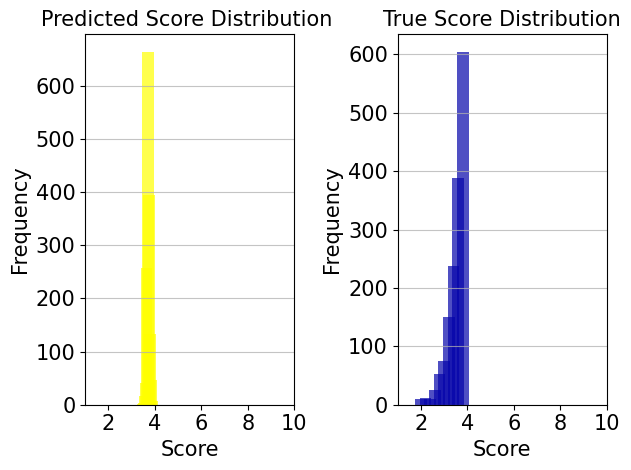

In [24]:
hist, bin_edges = np.histogram(score_list)
hist2, bin_edges2 = np.histogram(test_score_mean)
#plt.hist(test_score_mean, bins=[1,2,3,4,5,6,7,8,9,10],label="Test", color="red")
#plt.figure(figsize=[10,8])
plt.subplot(1,2,1)
plt.bar(bin_edges[:-1], hist, width = 0.5, color='yellow',alpha=0.7)
plt.xlim(1, 10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Score',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Predicted Score Distribution ',fontsize=15)
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(bin_edges2[:-1], hist2, width = 0.5, color='#0504aa',alpha=0.7)
plt.xlim(1, 10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Score',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('True Score Distribution',fontsize=15)
plt.tight_layout()
plt.show()